# importing libraries

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Setting repeating plotting parameters

In [40]:
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (13,9)
plt.rcParams['font.size'] = 20
warnings.filterwarnings('ignore')


# Importing dataset

In [41]:
binary_data = pd.read_csv('archive/detect_dataset.csv')

binary_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Output (S)  12001 non-null  int64  
 1   Ia          12001 non-null  float64
 2   Ib          12001 non-null  float64
 3   Ic          12001 non-null  float64
 4   Va          12001 non-null  float64
 5   Vb          12001 non-null  float64
 6   Vc          12001 non-null  float64
 7   Unnamed: 7  0 non-null      float64
 8   Unnamed: 8  0 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [42]:
binary_data.head()

,Output (S),Ia,Ib,Ic,Va,Vb,Vc,Unnamed: 7,Unnamed: 8
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,NaN,NaN
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,NaN,NaN
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,NaN,NaN
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,NaN,NaN
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,NaN,NaN


# Checking for null values

In [43]:
any(binary_data.isna().sum() > 0)


True

In [44]:
binary_data.drop(binary_data.iloc[:,[7,8]], axis=1, inplace=True)


In [45]:
binary_data.head()

,Output (S),Ia,Ib,Ic,Va,Vb,Vc
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050


# Data correlation

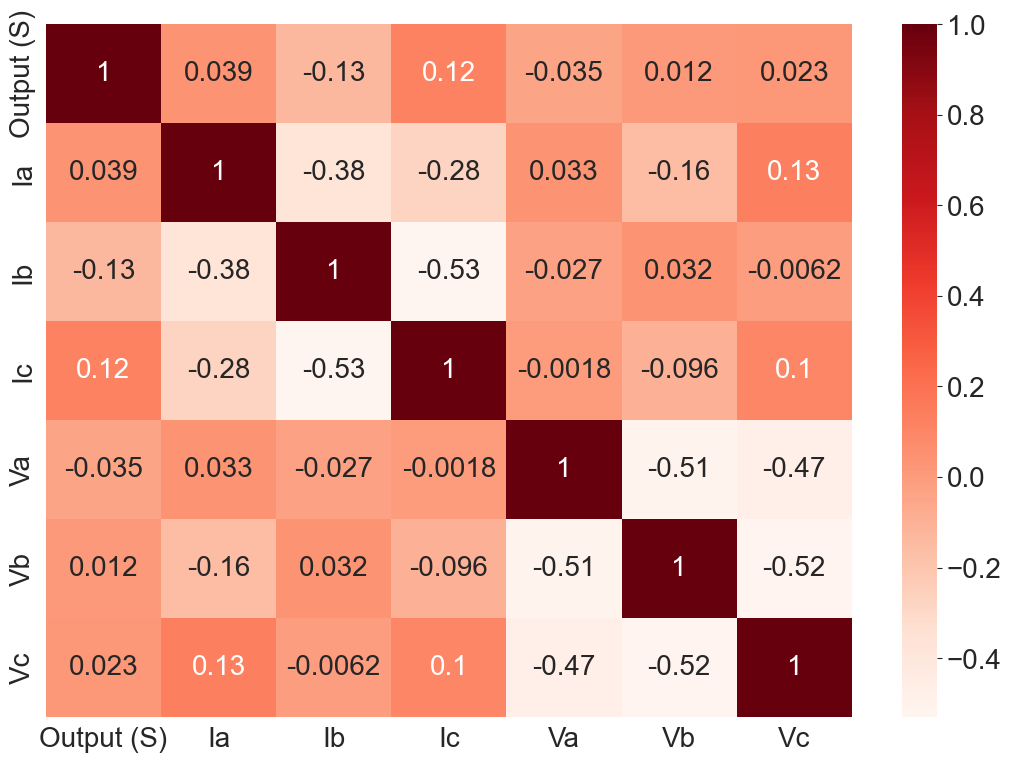

In [46]:
sns.heatmap(binary_data.corr(), annot=True, cmap='Reds')
plt.show()

# Investigating the relation between voltage and current in each phase of the transmission line

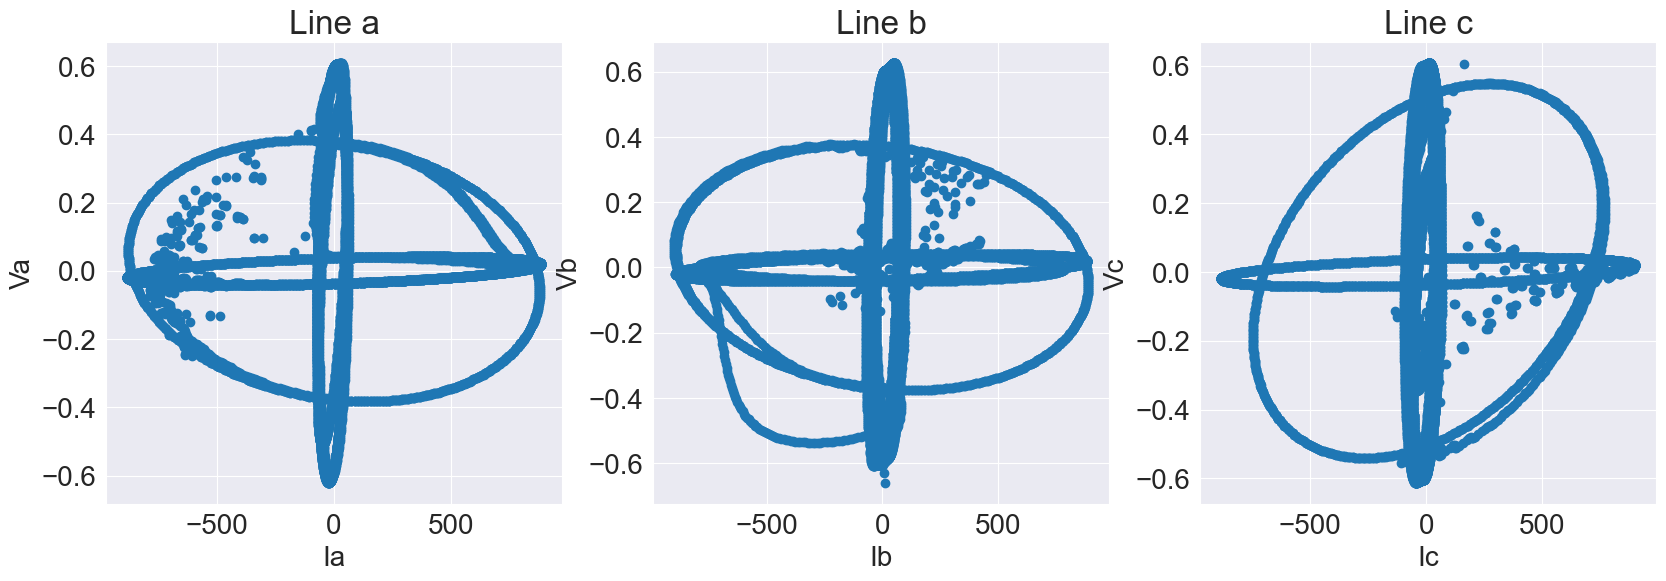

In [47]:
plt.figure(figsize=(20,6))

a1 = plt.subplot2grid((1,3),(0,0))
a1.scatter(binary_data['Ia'], binary_data['Va'])
a1.set_title('Line a')
a1.set_xlabel('Ia')
a1.set_ylabel('Va')

a2 = plt.subplot2grid((1,3),(0,1))
a2.scatter(binary_data['Ib'], binary_data['Vb'])
a2.set_title('Line b')
a2.set_xlabel('Ib')
a2.set_ylabel('Vb')

a3 = plt.subplot2grid((1,3),(0,2))
a3.scatter(binary_data['Ic'], binary_data['Vc'])
a3.set_title('Line c')
a3.set_xlabel('Ic')
a3.set_ylabel('Vc')

plt.show()


# Investigating  data imbalance

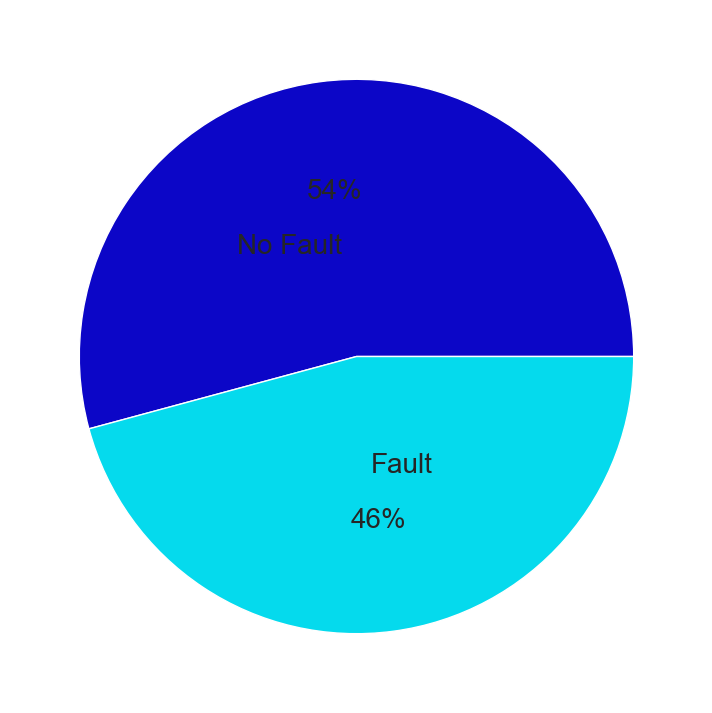

In [48]:
plt.pie(x=binary_data['Output (S)'].value_counts(), labels=['No Fault', 'Fault'],
        explode = [0, 0], autopct= '%1.f%%', labeldistance=0.4,
       colors=['#0c06c7', '#05daed'])
plt.show()


# Investigating data distributions

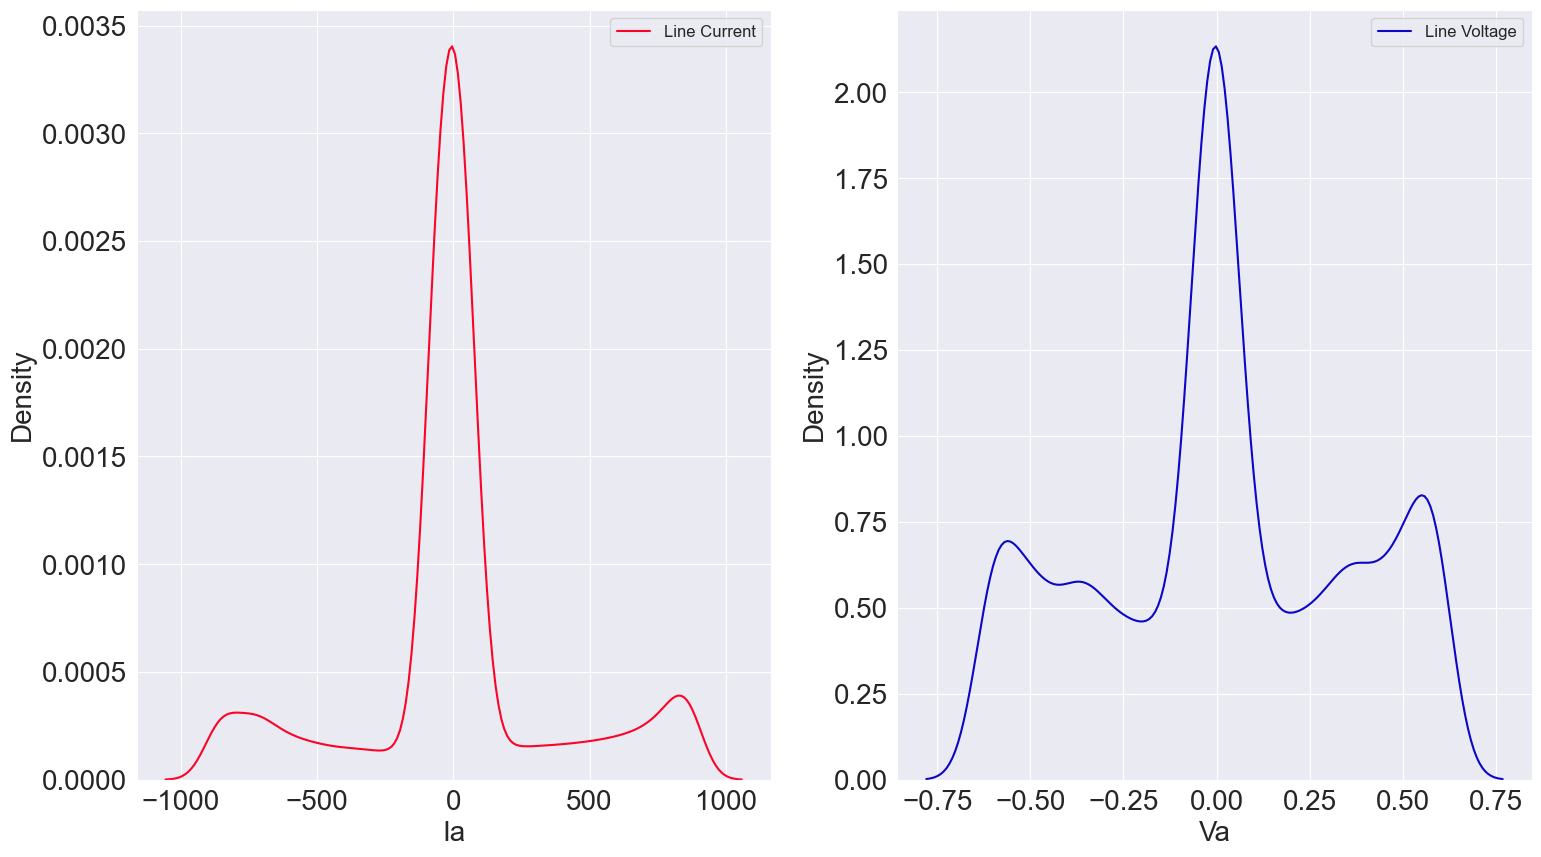

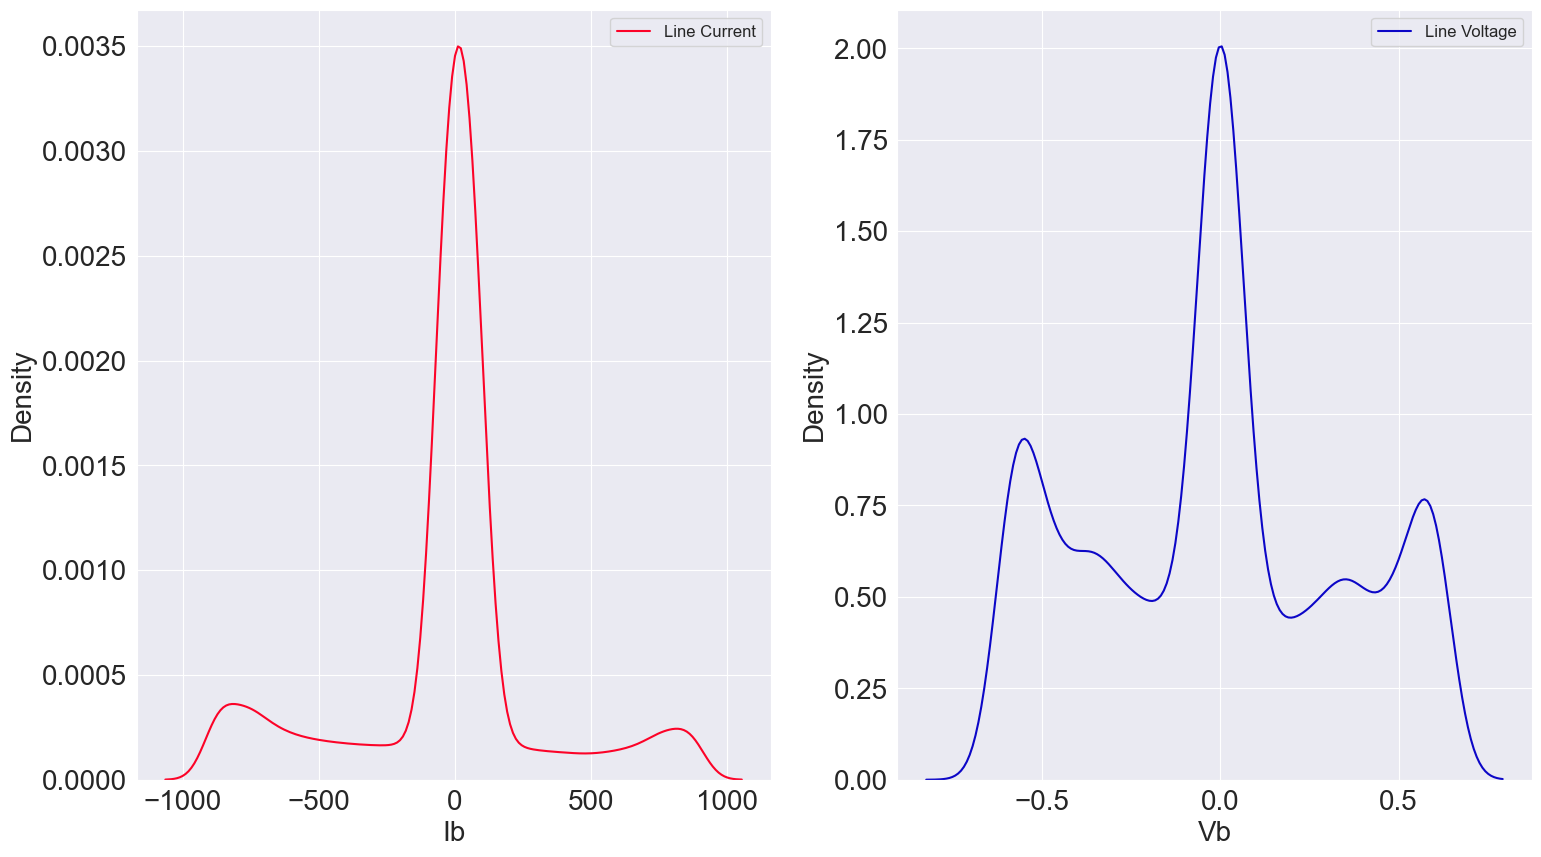

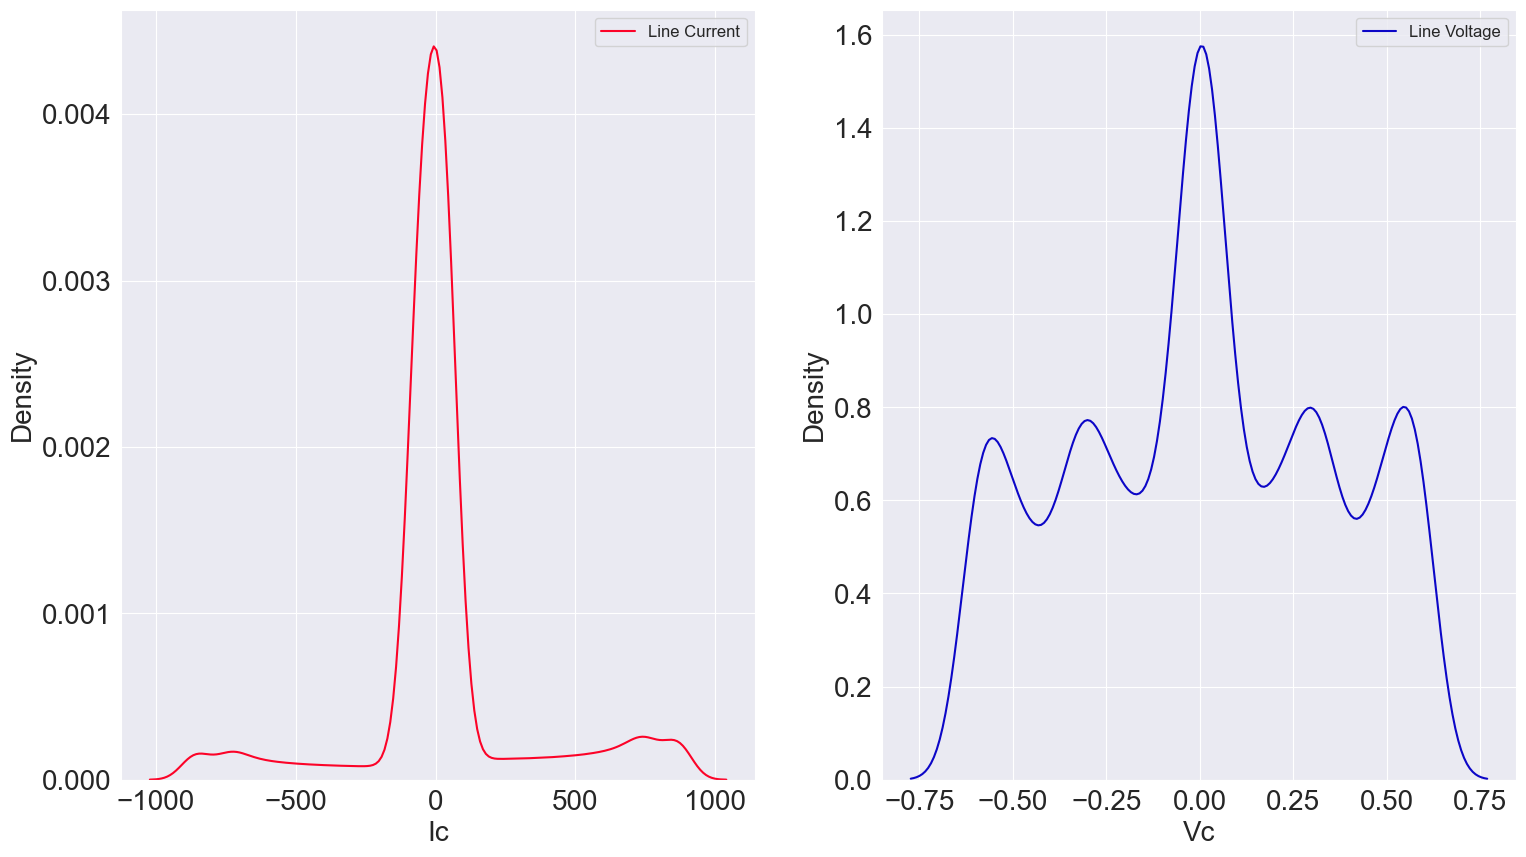

In [49]:
def dist(cola,colb):
    
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18,10))
    
    sns.distplot(binary_data[cola], label='Line Current', hist=False, color='#fc0328', ax=axs[0])
    sns.distplot(binary_data[colb], label='Line Voltage', hist=False, color='#0c06c7', ax=axs[1])
    
    axs[0].legend(loc='upper right', prop={'size': 12})
    axs[1].legend(loc='upper right', prop={'size': 12})
    
    plt.show()

lines = [
    ('Ia', 'Va'),
    ('Ib', 'Vb'),
    ('Ic', 'Vc')
]

for cola,colb in lines:
    dist(cola,colb)
    print('\n')


# Implementing the Decision trees model

In [50]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value
        
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left  = dataset[dataset[:,feature_index]<=threshold] 
        dataset_right = dataset[dataset[:,feature_index]> threshold] 
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

# Splitting the data

In [53]:
y = binary_data.iloc[:,0].values.reshape(-1,1)
X = binary_data.iloc[:,1:7].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9000, 6), (3001, 6), (9000, 1), (3001, 1))

# Training the model 

In [54]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,y_train)
classifier.print_tree()
y_train_pred = classifier.predict(X_train) 
y_test_pred = classifier.predict(X_test) 
y_train_score=accuracy_score(y_train, y_train_pred)
y_test_score=accuracy_score(y_test, y_test_pred)
print(y_train_score)
print(y_test_score)


X_1 <= -65.56306634 ? 0.152645287787658
 left:X_4 <= -0.514965028 ? 0.0003348545536654103
  left:X_0 <= 60.32105093 ? 0.19132653061224492
    left:0.0
    right:1.0
  right:X_3 <= 0.496603095 ? 0.0002705614974520675
    left:1.0
    right:X_0 <= 41.12358952 ? 0.375
        left:0.0
        right:1.0
 right:X_1 <= 100.2471406 ? 0.19216624923046394
  left:X_0 <= 63.42981746 ? 0.14834000366531563
    left:X_0 <= -83.7133742 ? 0.12440790685439344
        left:1.0
        right:0.0
    right:X_3 <= 0.369578768 ? 0.0019237283181514032
        left:1.0
        right:1.0
  right:1.0
0.9898888888888889
0.9903365544818394


# Training the model using scikit learn built in model

In [30]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=3, ccp_alpha=0.01)
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['fault', 'no fault']))



              precision    recall  f1-score   support

       fault       0.91      1.00      0.95      1634
    no fault       1.00      0.88      0.93      1367

    accuracy                           0.94      3001
   macro avg       0.95      0.94      0.94      3001
weighted avg       0.95      0.94      0.94      3001



In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=[0,1])

from sklearn.metrics import precision_score
precision_score(y_test, predictions)

from sklearn.metrics import recall_score
recall_score(y_test, predictions)

0.8763716166788588

In [32]:
feature_names = X.columns
feature_names

Index(['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'], dtype='object')

In [34]:
clf.feature_importances_

array([0.24216214, 0.75783786, 0.        , 0.        , 0.        ,
       0.        ])

In [35]:
feature_importance = pd.DataFrame(clf.feature_importances_, index = feature_names).sort_values(0, ascending=False)
feature_importance

,0
Ib,0.757838
Ia,0.242162
Ic,0.000000
Va,0.000000
Vb,0.000000
Vc,0.000000


In [36]:
features = list(feature_importance[feature_importance[0]>0].index)
features

['Ib', 'Ia']

<Axes: >

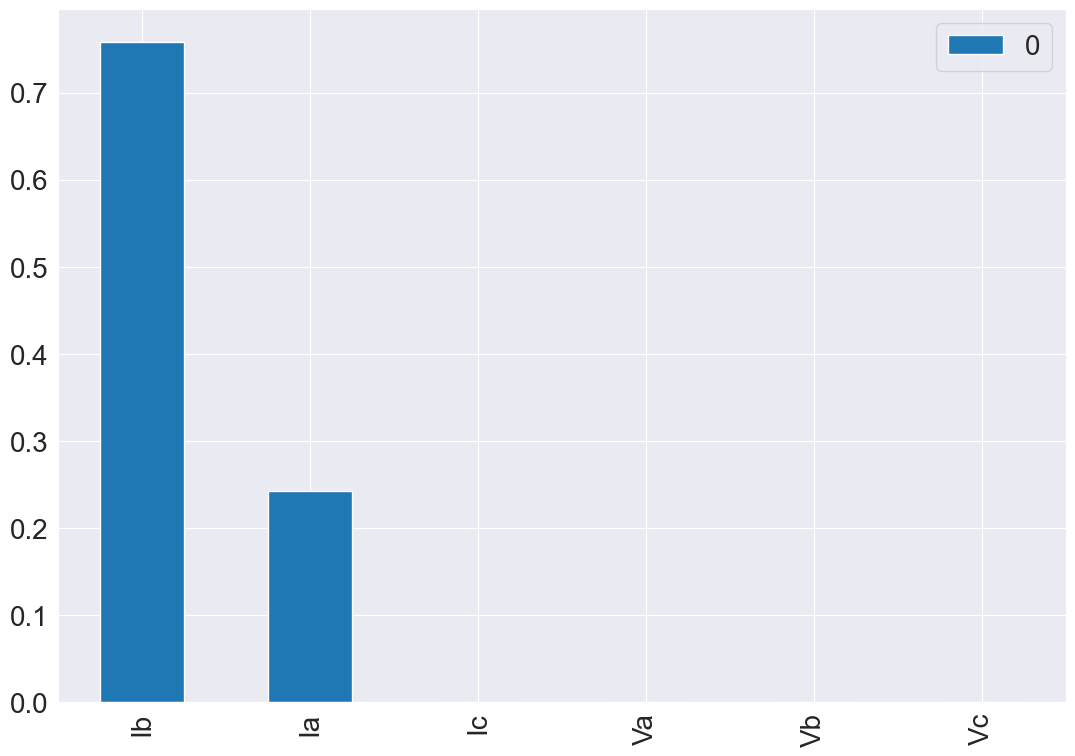

In [37]:

feature_importance.head(10).plot(kind='bar')

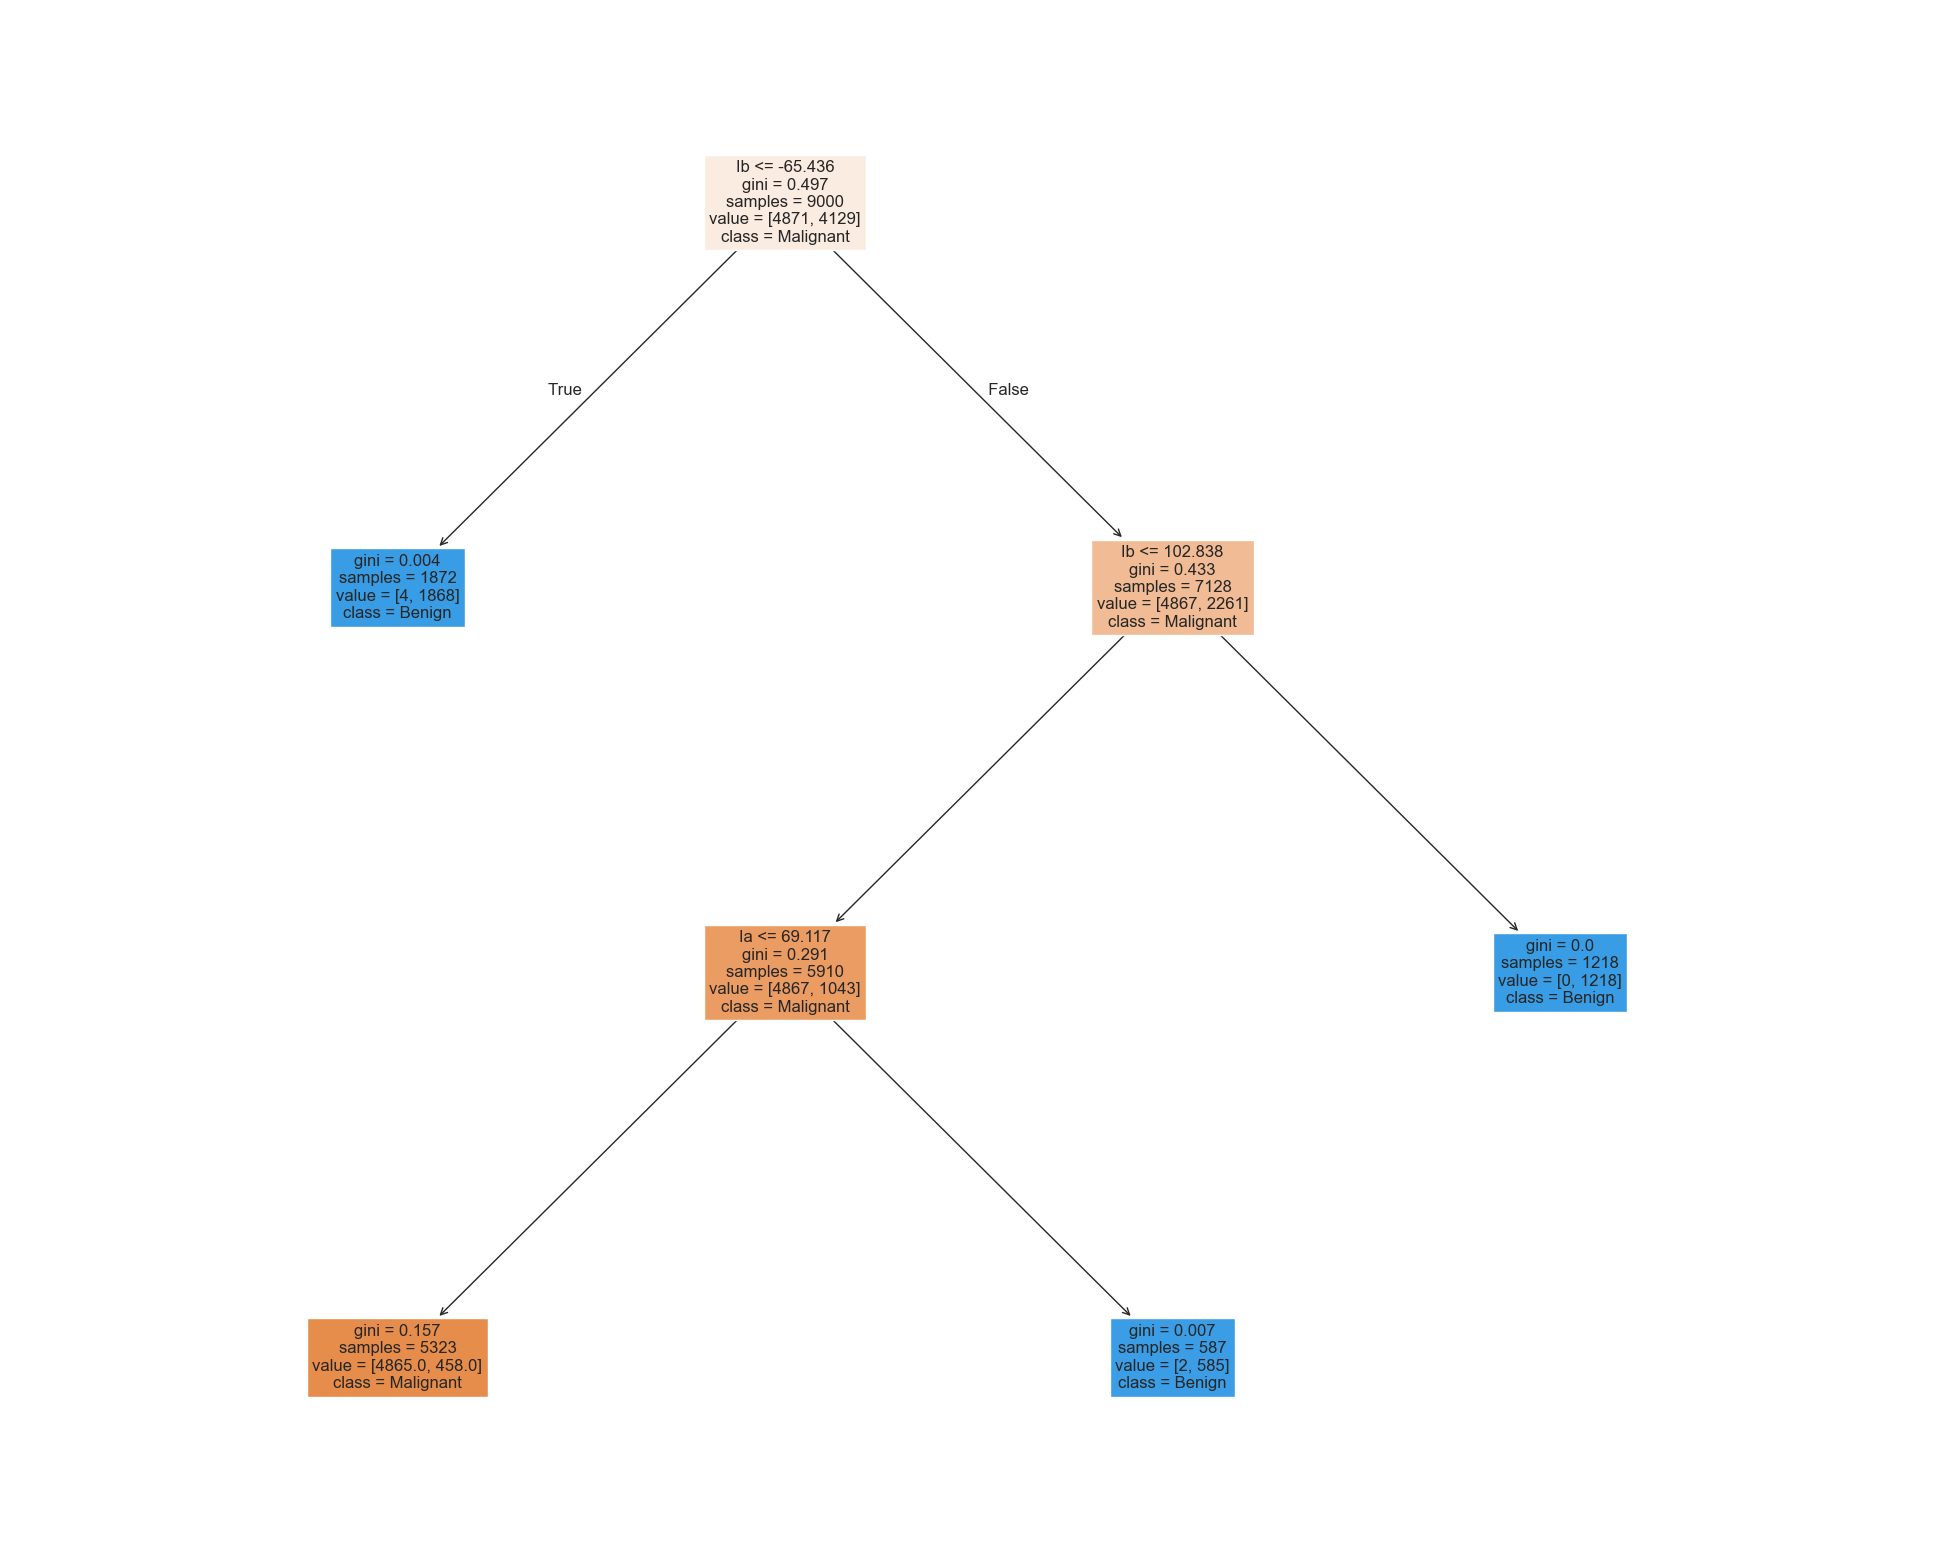

In [33]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=feature_names,  
                   class_names={0:'Malignant', 1:'Benign'},
                   filled=True,
                  fontsize=12)